<a href="https://colab.research.google.com/github/ivikhyatyadav/Digit-Classifier/blob/master/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.8.0


Import MNIST dataset.

In [3]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
def create_model():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Confirm that our model can achieve above 98% accuracy on MNIST dataset.

In [5]:
base_model = create_model()
base_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 150s 79ms/step - loss: 0.1366 - accuracy: 0.9588 - val_loss: 0.0538 - val_accuracy: 0.9830
Epoch 2/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.0400 - val_accuracy: 0.9874
Epoch 3/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0450 - val_accuracy: 0.9855
Epoch 4/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0365 - val_accuracy: 0.9871
Epoch 5/5
1875/1875 [==============================] - 150s 80ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.0316 - val_accuracy: 0.9907


# Troubleshoot the accuracy drop

Let's see the digit images in MNIST again and guess the cause of the accuracy drop we experienced in deployment.

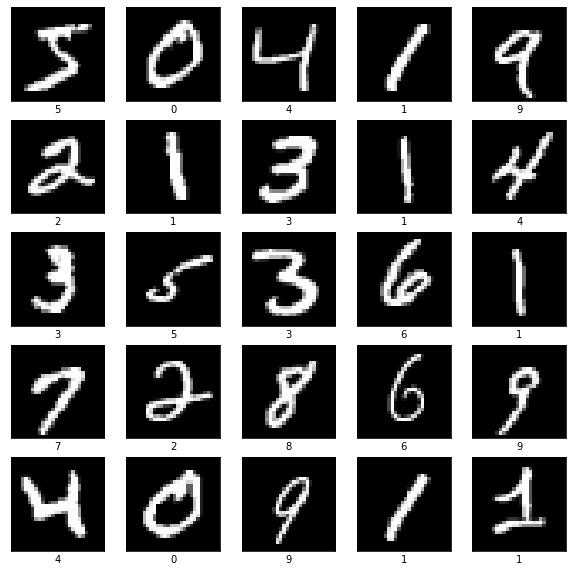

In [6]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

We can see from the 25 images above that the digits are about the same size, and they are in the center of the images. Let's verify if this assumption is true across the MNIST dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a203a6210>,
      dtype=object)

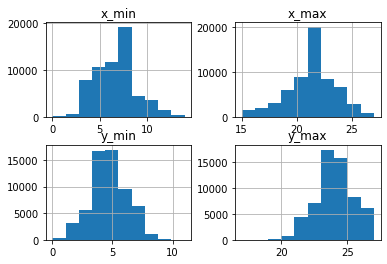

In [7]:
# An utility function that returns where the digit is in the image.
def digit_area(mnist_image):
  # Remove the color axes
  mnist_image = np.squeeze(mnist_image, axis=2)

  # Extract the list of columns that contain at least 1 pixel from the digit
  x_nonzero = np.nonzero(np.amax(mnist_image, 0))
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)

  # Extract the list of rows that contain at least 1 pixel from the digit
  y_nonzero = np.nonzero(np.amax(mnist_image, 1))
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)

  return [x_min, x_max, y_min, y_max]

# Calculate the area containing the digit across MNIST dataset
digit_area_rows = []
for image in train_images:
  digit_area_row = digit_area(image)
  digit_area_rows.append(digit_area_row)
digit_area_df = pd.DataFrame(
  digit_area_rows,
  columns=['x_min', 'x_max', 'y_min', 'y_max']
)
digit_area_df.hist()

However, when you wrote digits in your Android app, you probably did not pay attention to make sure your digit fit in the virtual area that the digits appear in MNIST dataset. The machine learning model have not seen such data before so it performed poorly, especially when you wrote a digit that was off the center of the drawing pad.

Let's add some data augmentation to the MNIST dataset to verify if our assumption is true. We will distort our MNIST dataset by adding:

Rotation
Width and height shift
Shear
Zoom

In [8]:
# Define data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.2
)

# Generate augmented data from MNIST dataset
train_generator = datagen.flow(train_images, train_labels)
test_generator = datagen.flow(test_images, test_labels)

Let's see what our digit images look like after augmentation. We can see that we now clearly have much more variation on how the digits are placed in the images.

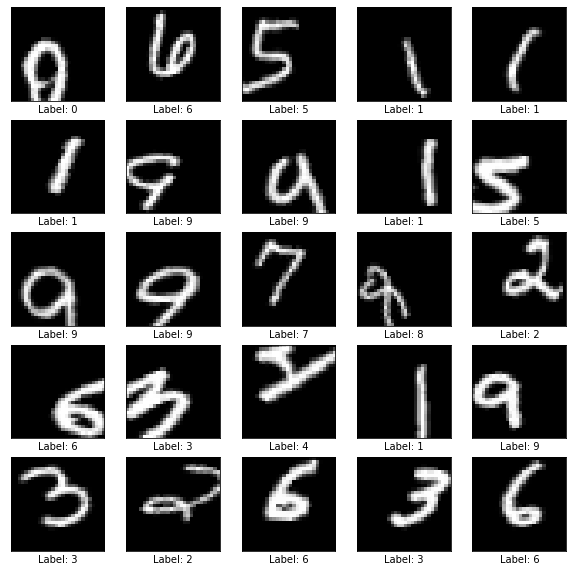

In [9]:
augmented_images, augmented_labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
    plt.xlabel('Label: %d' % augmented_labels[i])
plt.show()

Let's evaluate the digit classifier model that we trained earlier on this augmented test dataset and see if it makes accuracy drop.

In [10]:
base_model.evaluate(test_generator)

313/313 [==============================] - 9s 30ms/step - loss: 5.5436 - accuracy: 0.3265


[5.543581485748291, 0.3264999985694885]

Now let's train our model using augmented dataset to make it perform better in deployment.

In [11]:
improved_model = create_model()
improved_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 [==============================] - 168s 89ms/step - loss: 1.0012 - accuracy: 0.6766 - val_loss: 0.5492 - val_accuracy: 0.8342
Epoch 2/5
1875/1875 [==============================] - 169s 90ms/step - loss: 0.5073 - accuracy: 0.8476 - val_loss: 0.3798 - val_accuracy: 0.8896
Epoch 3/5
1875/1875 [==============================] - 168s 90ms/step - loss: 0.3945 - accuracy: 0.8818 - val_loss: 0.3004 - val_accuracy: 0.9118
Epoch 4/5
1875/1875 [==============================] - 169s 90ms/step - loss: 0.3468 - accuracy: 0.8967 - val_loss: 0.2763 - val_accuracy: 0.9188
Epoch 5/5
1875/1875 [==============================] - 169s 90ms/step - loss: 0.3151 - accuracy: 0.9054 - val_loss: 0.2521 - val_accuracy: 0.9209


# Convert to TensorFlow Lite

In [12]:
# Convert Keras model to TF Lite format and quantize.
converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp8e43p4b8/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>